# **Cyclists Outlier Detection**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Read the dataset from a CSV file
cyclists_df = pd.read_csv('../dataset/cyclists_clustering.csv')

columns_to_keep = ["avg_relative_position", "career_level", "min_relative_position"] 

cluster_0_drop = list(set(cyclists_df.select_dtypes(include=[np.number]).columns) - set(columns_to_keep))

cyclists_with_outlier_score = cyclists_df.copy()

cyclists_df = cyclists_df.select_dtypes(include=[np.number])
cyclists_df = cyclists_df.drop(columns=cluster_0_drop)
cyclist_numeric_columns = cyclists_df.columns.to_list()

scaler = MinMaxScaler()
cyclists_df = pd.DataFrame(scaler.fit_transform(cyclists_df), columns=cyclists_df.columns)

cyclists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3546 entries, 0 to 3545
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   avg_relative_position  3546 non-null   float64
 1   min_relative_position  3546 non-null   float64
 2   career_level           3546 non-null   float64
dtypes: float64(3)
memory usage: 83.2 KB


## Connectivity approach


In [3]:
from sklearn.neighbors import LocalOutlierFactor

k = 15

algorithm = LocalOutlierFactor(n_neighbors=k)
algorithm.fit(cyclists_df)

# negated outlier scores: the higher, the more of an outlier
outlier_degrees = - algorithm.negative_outlier_factor_
cyclists_with_outlier_score.loc[:, "lof_degree"] = outlier_degrees

Plot the lof degree to understand where to put a threshold

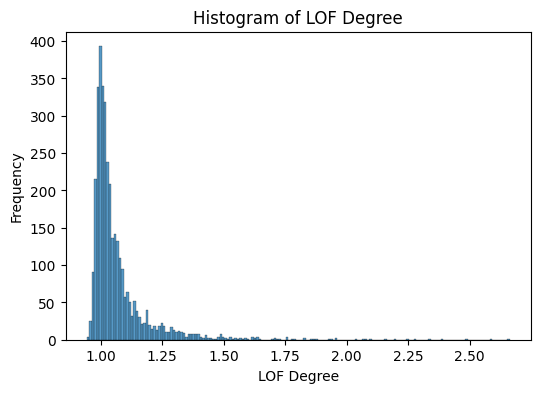

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # Set the figure size
sns.histplot(outlier_degrees, binwidth=0.01)
plt.xlabel('LOF Degree')
plt.ylabel('Frequency')
plt.title('Histogram of LOF Degree')
plt.show()

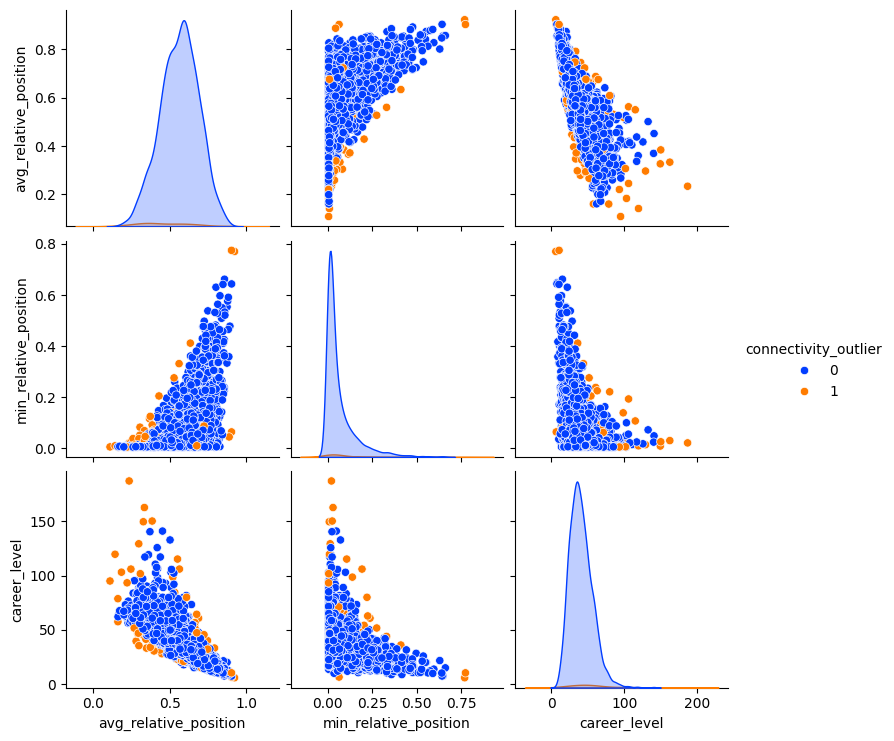

In [5]:

threshold = 1.4 # 1.4 for less outliers

# Threshold and map to {0: inlier, 1: outlier}
cyclists_with_outlier_score['connectivity_outlier'] = (cyclists_with_outlier_score['lof_degree'] > threshold).astype(int)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ['connectivity_outlier']], hue='connectivity_outlier', diag_kind='kde', palette='bright')
plt.show()

Counting outliers identified

In [6]:
cyclists_with_outlier_score["connectivity_outlier"].value_counts()

connectivity_outlier
0    3456
1      90
Name: count, dtype: int64

Analyze some of them

In [7]:
outliers = cyclists_with_outlier_score[cyclists_with_outlier_score['connectivity_outlier'] == 1]
outliers.drop(columns="connectivity_outlier").head()

,_url,name,birth_year,nationality,cyclist_experience,cyclist_win,cyclist_win_ratio,avg_relative_position,relative_position_std,mean_last_10_positions,...,performance_entropy,weighted_podiums,career_level,avg_position,best_position,best_position_std,top_cyclists,top_experience,continent,lof_degree
54,juan-ayuso-pesquera,Juan Ayuso,2002,Spain,53,3,0.056604,0.160543,0.149235,0.306570,...,3.586042,7.245283,57.505703,22.094340,0,21.078848,Top 500,Top 3000,Europe,1.523723
67,tadej-pogacar,Tadej Pogačar,1998,Slovenia,166,30,0.180723,0.108822,0.131496,0.364758,...,4.549214,30.903614,94.953446,14.313253,0,18.713423,Top 50,Top 1300,Europe,2.391444
76,louis-de-koning,Louis de Koning,1967,Netherlands,20,0,0.000000,0.687269,0.240623,0.669026,...,2.933120,0.000000,60.746316,59.700000,4,33.327877,Top 500,Rest,Europe,2.062811
117,antonio-tiberi,Antonio Tiberi,2001,Italy,60,0,0.000000,0.436924,0.267722,0.731187,...,3.903242,0.000000,34.211623,62.283333,7,40.229465,Top 2500,Top 2500,Europe,1.578254
138,nico-verhoeven,Nico Verhoeven,1961,Netherlands,110,1,0.009091,0.531477,0.323297,0.913248,...,4.491108,2.263636,84.457540,69.636364,0,66.177926,Top 150,Top 2000,Europe,1.411181


## One-class SVM


In [8]:
from sklearn.svm import OneClassSVM


kernel = "rbf"      # "linear", "poly", "rbf", "sigmoid"
algorithm = OneClassSVM(kernel=kernel, nu=0.025) #0.04 for less outliers
algorithm.fit(cyclists_df)

# this implementation provides two different scores:
#   outlier classification in {+1, -1}
#   outlier scores in R: distance from hyperplane
outlier_classification_scores = algorithm.predict(cyclists_df)

outlier_distance_scores = algorithm.score_samples(cyclists_df)

cyclists_with_outlier_score.loc[:, "svm_degree"] = outlier_distance_scores
# map to {0: inliers, : outliers}
cyclists_with_outlier_score.loc[:, "svm_outlier"] = -(outlier_classification_scores  - 1) / 2  

if kernel == "linear":
    support_vectors = cyclists_df.iloc[algorithm.support_]
    
else:
    support_vectors = None

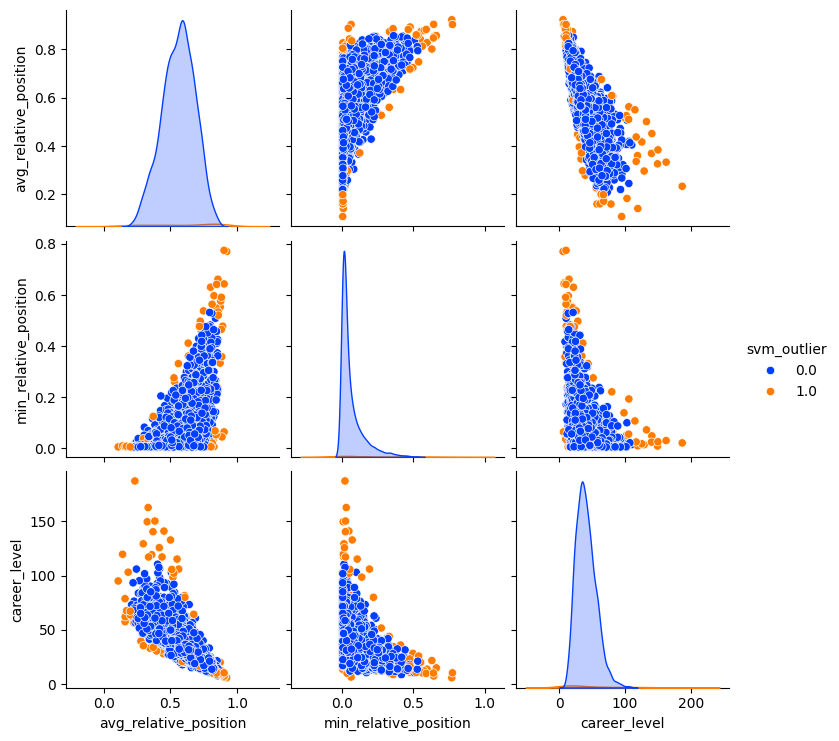

In [9]:
# Classify points as outliers or not

cyclists_with_outlier_score.drop(columns=['svm_degree'], inplace=True)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ["svm_outlier"]], hue='svm_outlier', diag_kind='kde', palette='bright')
plt.show()

In [10]:
cyclists_with_outlier_score["svm_outlier"].value_counts()

svm_outlier
0.0    3458
1.0      88
Name: count, dtype: int64

Analyze some of them

In [11]:
outliers = cyclists_with_outlier_score[cyclists_with_outlier_score['svm_outlier'] == 1]
outliers.drop(columns=["svm_outlier"]).head()

,_url,name,birth_year,nationality,cyclist_experience,cyclist_win,cyclist_win_ratio,avg_relative_position,relative_position_std,mean_last_10_positions,...,weighted_podiums,career_level,avg_position,best_position,best_position_std,top_cyclists,top_experience,continent,lof_degree,connectivity_outlier
54,juan-ayuso-pesquera,Juan Ayuso,2002,Spain,53,3,0.056604,0.160543,0.149235,0.306570,...,7.245283,57.505703,22.094340,0,21.078848,Top 500,Top 3000,Europe,1.523723,1
67,tadej-pogacar,Tadej Pogačar,1998,Slovenia,166,30,0.180723,0.108822,0.131496,0.364758,...,30.903614,94.953446,14.313253,0,18.713423,Top 50,Top 1300,Europe,2.391444,1
179,frans-verbeeck,Frans Verbeeck,1941,Belgium,52,6,0.115385,0.233856,0.192032,0.295247,...,74.903846,186.969293,5.115385,0,4.509919,Top 20,Top 3000,Europe,2.201240,1
196,christian-poos,Christian Poos,1977,Luxembourg,26,0,0.000000,0.447517,0.234647,0.530958,...,1.538462,28.053150,51.076923,2,25.397517,Top 3000,Top 3500,Europe,2.158158,1
230,viktor-rjaksinski,Viktor Rjaksinski,1967,Ukraine,21,0,0.000000,0.634458,0.139967,0.626745,...,0.000000,34.549562,85.523810,57,17.348254,Top 2500,Top 3500,Europe,1.235763,0


Analyze which cyclists has both outlier score positive

In [12]:
outliers = cyclists_with_outlier_score[(cyclists_with_outlier_score['svm_outlier'] == 1) & (cyclists_with_outlier_score['connectivity_outlier'] == 1)]
print(f"In total there are {int(len(outliers))} data with both outlier scores positive\n")
outliers.drop(columns=["svm_outlier", "connectivity_outlier"]).head()


In total there are 31 data with both outlier scores positive



,_url,name,birth_year,nationality,cyclist_experience,cyclist_win,cyclist_win_ratio,avg_relative_position,relative_position_std,mean_last_10_positions,...,performance_entropy,weighted_podiums,career_level,avg_position,best_position,best_position_std,top_cyclists,top_experience,continent,lof_degree
54,juan-ayuso-pesquera,Juan Ayuso,2002,Spain,53,3,0.056604,0.160543,0.149235,0.306570,...,3.586042,7.245283,57.505703,22.094340,0,21.078848,Top 500,Top 3000,Europe,1.523723
67,tadej-pogacar,Tadej Pogačar,1998,Slovenia,166,30,0.180723,0.108822,0.131496,0.364758,...,4.549214,30.903614,94.953446,14.313253,0,18.713423,Top 50,Top 1300,Europe,2.391444
179,frans-verbeeck,Frans Verbeeck,1941,Belgium,52,6,0.115385,0.233856,0.192032,0.295247,...,3.659394,74.903846,186.969293,5.115385,0,4.509919,Top 20,Top 3000,Europe,2.201240
196,christian-poos,Christian Poos,1977,Luxembourg,26,0,0.000000,0.447517,0.234647,0.530958,...,3.111610,1.538462,28.053150,51.076923,2,25.397517,Top 3000,Top 3500,Europe,2.158158
507,sho-hatsuyama,Sho Hatsuyama,1988,Japan,36,0,0.000000,0.921734,0.059300,0.940074,...,3.581453,0.000000,5.948487,139.527778,115,15.509419,NaN,Top 3000,Asia,1.958657


## Isolation forest


In [13]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest algorithm with a lower contamination value
isolation_forest = IsolationForest(n_estimators=200, contamination=0.020, n_jobs=-1, random_state=42)
isolation_forest.fit(cyclists_df)

# Compute the outlier scores
outlier_scores = isolation_forest.decision_function(cyclists_df)       # negative values are outliers
outlier_predictions = isolation_forest.predict(cyclists_df)

# Add the outlier scores to the dataframe
cyclists_with_outlier_score['isolation_forest_score'] = outlier_scores
cyclists_with_outlier_score['isolation_forest_outlier'] = (outlier_predictions == -1).astype(int)

print(cyclists_with_outlier_score['isolation_forest_outlier'].value_counts())

isolation_forest_outlier
0    3475
1      71
Name: count, dtype: int64


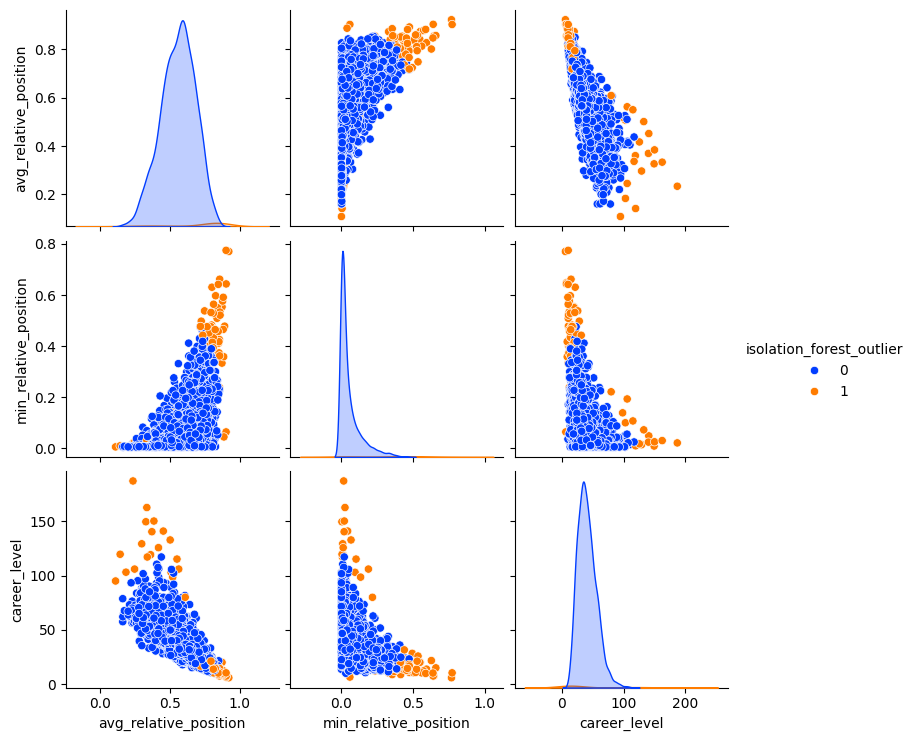

In [14]:
cyclists_with_outlier_score.drop(columns=['isolation_forest_score'], inplace=True)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ["isolation_forest_outlier"]], hue="isolation_forest_outlier", diag_kind='kde', palette='bright')
plt.show()

## ENSAMBLING DECISION

Check when at least two outlier score are positive to classify a point as an outlier

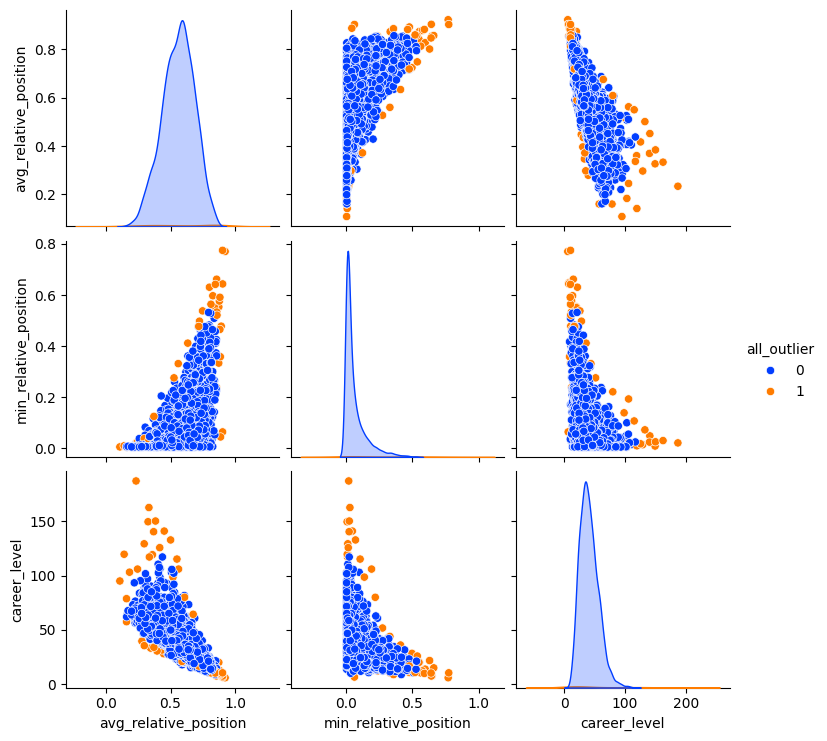

In [15]:
cond1 = (cyclists_with_outlier_score['isolation_forest_outlier'] == 1) & (cyclists_with_outlier_score['svm_outlier'] == 1) 
cond2 = (cyclists_with_outlier_score['isolation_forest_outlier'] == 1) & (cyclists_with_outlier_score['connectivity_outlier'] == 1)
cond3 = (cyclists_with_outlier_score['svm_outlier'] == 1) & (cyclists_with_outlier_score['connectivity_outlier'] == 1)
cond = cond1 | cond2 | cond3

cyclists_with_outlier_score['all_outlier'] = (cond).astype(int)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ["all_outlier"]], hue='all_outlier', diag_kind='kde', palette='bright')
plt.show()

Count how many outliers individued by ensambling methods

In [16]:
print(cyclists_with_outlier_score['all_outlier'].value_counts())

all_outlier
0    3487
1      59
Name: count, dtype: int64


### Trying to characterize the outlier

First isolate outliers in a separate df in order to analyze the distribution of removed rows

In [17]:
outlier_df = cyclists_with_outlier_score[cyclist_numeric_columns + ['all_outlier']]
outlier_df = outlier_df[outlier_df['all_outlier'] == 1]

# Normalize the data
normalized_outlier_df = pd.DataFrame(scaler.transform(outlier_df[cyclist_numeric_columns]), columns=cyclist_numeric_columns)

print(normalized_outlier_df.describe())

       avg_relative_position  min_relative_position  career_level
count              59.000000              59.000000     59.000000
mean                0.588393               0.326984      0.277669
std                 0.317588               0.338226      0.286970
min                 0.000000               0.000375      0.000000
25%                 0.315052               0.023487      0.034649
50%                 0.557676               0.156269      0.141030
75%                 0.918455               0.678475      0.544333
max                 1.000000               1.000000      1.000000


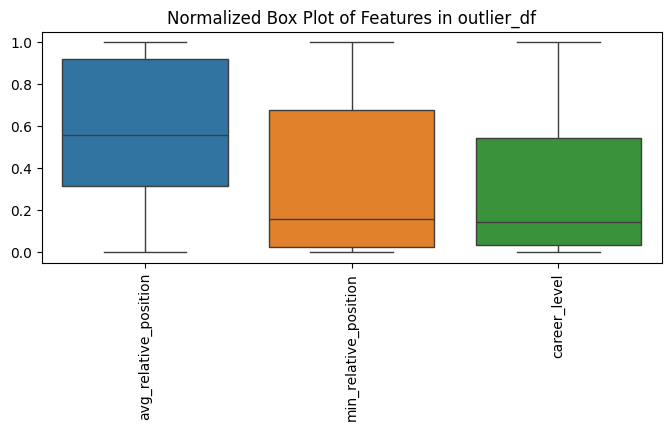

In [18]:
 # Create a box plot
plt.figure(figsize=(8, 3))
sns.boxplot(data=normalized_outlier_df[cyclist_numeric_columns])
plt.xticks(rotation=90)
plt.title('Normalized Box Plot of Features in outlier_df')
plt.show()

### Characterizing remaining rows

Plot distribution of remaining columns after outlier detection

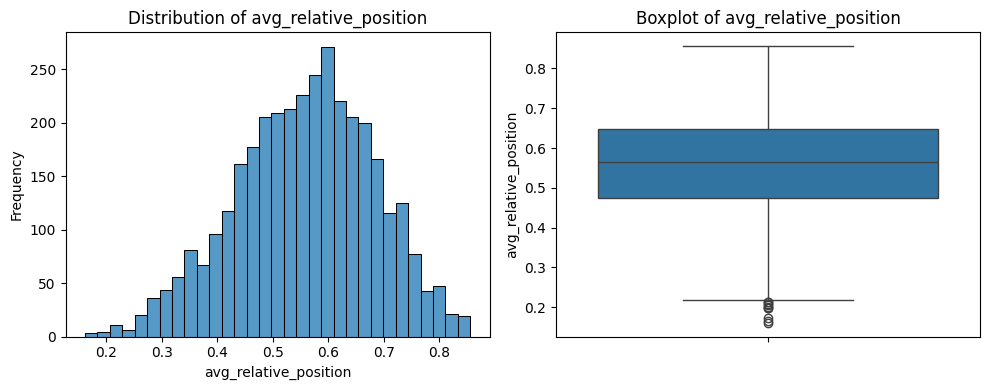

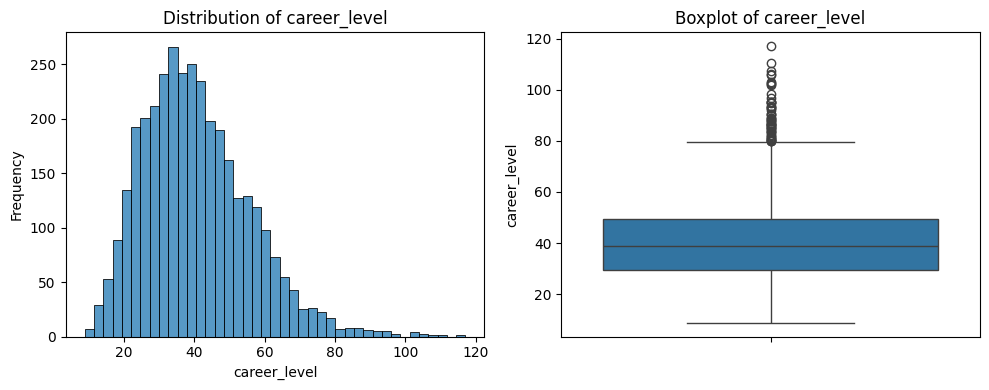

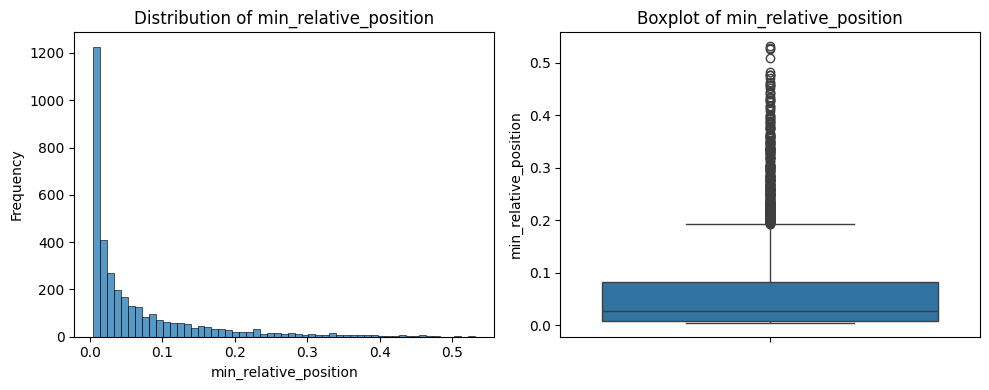

In [54]:
for feature in columns_to_keep:
    plt.figure(figsize=(10, 4))  # Resize the figure
    plt.subplot(1, 2, 1)
    sns.histplot(cyclists_with_outlier_score[feature])
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=cyclists_with_outlier_score[feature])
    plt.title(f'Boxplot of {feature}')
    
    plt.tight_layout()
    plt.show()

After outlier detection we first analyze how many cyclists for each bin in top cyclists column how many cyclists were removed by the algorithm.
recall: top cyclists is a categorical feature that stores cyclists by career level values 

In [20]:
cyclists_with_outlier_score = cyclists_with_outlier_score[cyclists_with_outlier_score['all_outlier'] != 1]
cyclists_with_outlier_score.drop(columns=['connectivity_outlier', 'svm_outlier', 'isolation_forest_outlier' ,'all_outlier', 'lof_degree'], inplace=True)

In [21]:
cyclists_with_outlier_score.value_counts("top_cyclists")

top_cyclists
Rest        521
Top 3000    496
Top 2500    495
Top 1700    398
Top 500     348
Top 1300    300
Top 2000    300
Top 750     250
Top 1000    249
Top 150      98
Top 50       27
Top 20        5
Name: count, dtype: int64

#### Rescaling ```top_cyclists``` column after outlier detection

In [22]:
# Sort the cyclists_df DataFrame by the 'career_level' column in descending order
sorted_cyclists_df = cyclists_with_outlier_score.sort_values(by='career_level', ascending=False)

# Define the bins and labels
"""bins = [0, 21, 51, 151, 501, 1001, 1501, 2001, 2501, 3001, 3501, len(sorted_cyclists_df)]
labels = ['Top 20', 'Top 50', 'Top 150', 'Top 500', 'Top 1000', 'Top 1501', 'Top 2000', 'Top 2500', 'Top 3000','Top 3500', 'Rest']
"""

# Define the bins and labels
bins = [0, 21, 51, 151, 501, 751, 1001, 1301, 1701, 2001, 2501, 3001, len(sorted_cyclists_df)]
labels = ['Top 20', 'Top 50', 'Top 150', 'Top 500', 'Top 750', 'Top 1000', 'Top 1300', 'Top 1700', 'Top 2000', 'Top 2500', 'Top 3000', 'Rest']

# Create a new column 'career_level_category' based on the bins
sorted_cyclists_df['top_cyclists'] = pd.cut(range(1, len(sorted_cyclists_df) + 1), bins=bins, labels=labels, right=False)

cyclists_with_outlier_score.drop(columns=['top_cyclists'], inplace=True)
# Add the 'top_cyclists' column to the original cyclists_df
cyclists_with_outlier_score = cyclists_with_outlier_score.merge(sorted_cyclists_df[['_url', 'top_cyclists']], on='_url', how='left')


Analyzig feature distrbution of rest column to trying to somehow understand the feature value of cyclists with a low career level

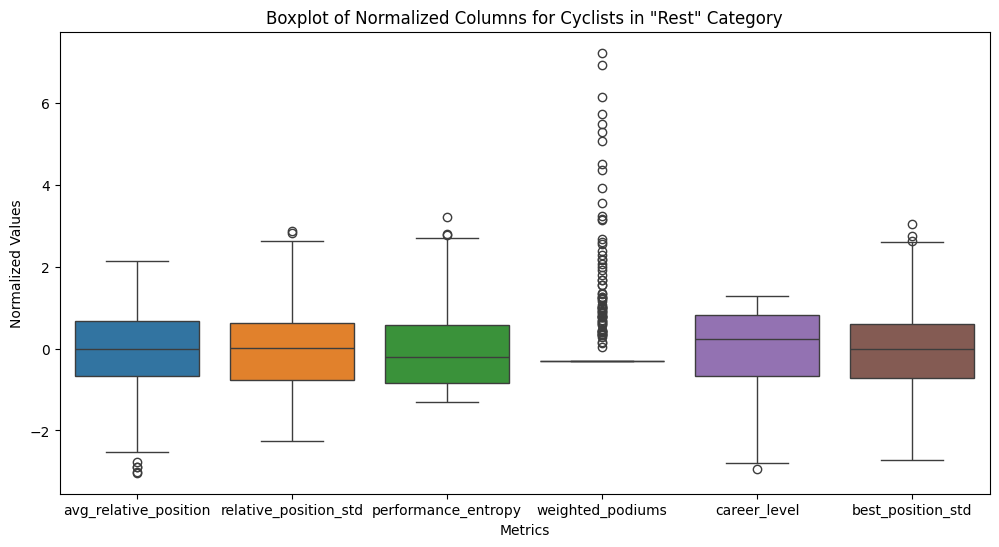

In [23]:
from sklearn.preprocessing import StandardScaler

# Filter the dataframe for rows where top_cyclists is 'Rest'
rest_cyclists_df = cyclists_with_outlier_score[cyclists_with_outlier_score['top_cyclists'] == 'Rest']

# Select the columns to be normalized
columns_to_normalize = ['avg_relative_position', 'relative_position_std', 'performance_entropy', 'weighted_podiums', 'career_level', 'best_position_std']

# Normalize the selected columns

scaler = StandardScaler()
normalized_data = scaler.fit_transform(rest_cyclists_df[columns_to_normalize])

# Create a new DataFrame with the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=columns_to_normalize)

# Plot the boxplot for the normalized columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=normalized_df)
plt.title('Boxplot of Normalized Columns for Cyclists in "Rest" Category')
plt.xlabel('Metrics')
plt.ylabel('Normalized Values')
plt.show()

### Scatter plot

Trying to analyizing if in our fetures there's some pattern concerning the career level feature

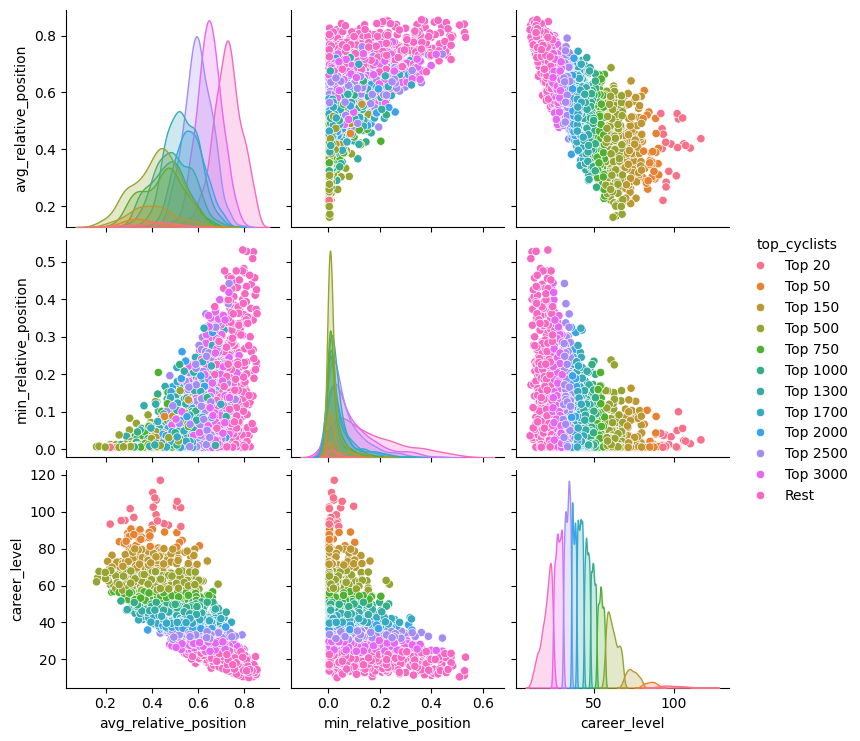

In [24]:
sns.pairplot(cyclists_with_outlier_score.drop(columns=cluster_0_drop), hue='top_cyclists')
plt.show()

### Saving the dataset

In [25]:
cyclists_with_outlier_score.columns

Index(['_url', 'name', 'birth_year', 'nationality', 'cyclist_experience',
       'cyclist_win', 'cyclist_win_ratio', 'avg_relative_position',
       'relative_position_std', 'mean_last_10_positions',
       'min_relative_position', 'avg_performance_vs_startlist',
       'performance_entropy', 'weighted_podiums', 'career_level',
       'avg_position', 'best_position', 'best_position_std', 'top_experience',
       'continent', 'top_cyclists'],
      dtype='object')

In [26]:
cyclists_with_outlier_score.to_csv('../dataset/cyclists_outlier.csv', index=False)

---

# **Races Outlier Detection**

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os

races_df = pd.read_csv('../dataset/races_clustering.csv')

races_complexity_cluster_col = ["avg_cyclists_level", "race_importance"]  #["climb_total", "length"]

races_with_outlier_score = races_df.copy()

races_df = races_df.select_dtypes(include=[np.number])
races_df.drop(columns=['profile'], inplace=True)
races_numeric_columns = races_df[races_complexity_cluster_col].columns.to_list()

scaler = MinMaxScaler()
races_df = pd.DataFrame(scaler.fit_transform(races_df), columns=races_df.columns)

races_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2614 entries, 0 to 2613
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   points              2614 non-null   float64
 1   length              2614 non-null   float64
 2   climb_total         2614 non-null   float64
 3   startlist_quality   2614 non-null   float64
 4   cyclist_number      2614 non-null   float64
 5   avg_cyclists_level  2614 non-null   float64
 6   average_age         2614 non-null   float64
 7   race_importance     2614 non-null   float64
 8   difficulty_idx      2614 non-null   float64
 9   avg_slope           2614 non-null   float64
 10  min_duration        2614 non-null   float64
 11  duration_to_length  2614 non-null   float64
 12  startlist_entropy   2614 non-null   float64
 13  points_entropy      2614 non-null   float64
 14  difficulty_index_2  2614 non-null   float64
dtypes: float64(15)
memory usage: 306.5 KB


## Connectivity approach


In [28]:
from sklearn.neighbors import LocalOutlierFactor

k = 15

algorithm = LocalOutlierFactor(n_neighbors=k)
algorithm.fit(races_df)

# negated outlier scores: the higher, the more of an outlier
outlier_degrees = - algorithm.negative_outlier_factor_
races_with_outlier_score.loc[:, "lof_degree"] = outlier_degrees

Plot the lof degree to understand where to put a threshold

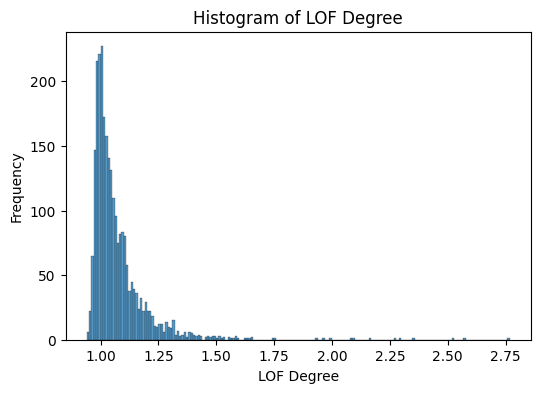

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # Set the figure size
sns.histplot(outlier_degrees, binwidth=0.01)
plt.xlabel('LOF Degree')
plt.ylabel('Frequency')
plt.title('Histogram of LOF Degree')
plt.show()

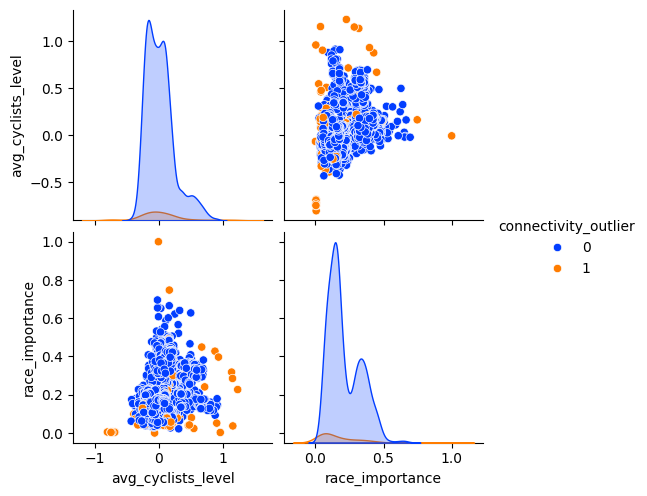

In [30]:

threshold = 1.28 # 1.4 for less outliers

# Threshold and map to {0: inlier, 1: outlier}
races_with_outlier_score['connectivity_outlier'] = (races_with_outlier_score['lof_degree'] > threshold).astype(int)

sns.pairplot(races_with_outlier_score[races_numeric_columns + ['connectivity_outlier']], hue='connectivity_outlier', diag_kind='kde', palette='bright')
plt.show()

Counting outliers identified

In [31]:
races_with_outlier_score["connectivity_outlier"].value_counts()

connectivity_outlier
0    2468
1     146
Name: count, dtype: int64

Analyze some of them

In [32]:
outliers = races_with_outlier_score[races_with_outlier_score['connectivity_outlier'] == 1]
outliers.drop(columns="connectivity_outlier").head()

,_url,name,points,length,climb_total,profile,startlist_quality,is_tarmac,start_date,duration,...,season,avg_slope,min_duration,duration_to_length,real_name,startlist_entropy,points_entropy,difficulty_index_2,top_complex_races_2,lof_degree
13,dauphine/2013/stage-1,Critérium du Dauphiné,50.0,1.210,2.582,2.0,985,True,2013-06-02,03:17:35,...,Spring,213.3884,3.293056,27.2153,dauphine,3.528066,-0.000000,0.422860,Top 1700,1.459744
71,dauphine/2020/stage-5,Critérium du Dauphiné,50.0,1.425,4.391,5.0,1243,True,2020-08-16,03:58:39,...,Summer,308.1404,3.977500,27.9123,dauphine,3.528066,-0.000000,1.377158,Top 50,1.288642
96,dwars-door-vlaanderen/2016/result,Dwars door Vlaanderen / A travers la Flandre,125.0,1.997,1.318,2.0,460,False,2016-03-23,04:48:27,...,Spring,65.9990,4.807500,24.0736,dwars-door-vlaanderen,2.807355,0.591673,0.342619,Top 2000,1.585300
115,giro-d-italia/2000/stage-1,Giro d'Italia,80.0,1.250,0.691,2.0,866,True,2000-05-14,02:46:46,...,Spring,55.2800,2.779444,22.2356,giro-d-italia,4.498913,0.128518,0.305631,Top 2000,1.391379
116,giro-d-italia/2000/stage-10,Giro d'Italia,80.0,2.570,1.880,2.0,866,True,2000-05-23,06:48:07,...,Spring,73.1518,6.801944,26.4667,giro-d-italia,4.498913,0.128518,0.382467,Top 1700,1.415199


## One-class SVM


In [33]:
from sklearn.svm import OneClassSVM


kernel = "rbf"      # "linear", "poly", "rbf", "sigmoid"
algorithm = OneClassSVM(kernel=kernel, nu=0.05) #0.04 for less outliers
algorithm.fit(races_df)

# this implementation provides two different scores:
#   outlier classification in {+1, -1}
#   outlier scores in R: distance from hyperplane
outlier_classification_scores = algorithm.predict(races_df)

outlier_distance_scores = algorithm.score_samples(races_df)

races_with_outlier_score.loc[:, "svm_degree"] = outlier_distance_scores
# map to {0: inliers, : outliers}
races_with_outlier_score.loc[:, "svm_outlier"] = -(outlier_classification_scores  - 1) / 2  

print(races_with_outlier_score['svm_outlier'].value_counts())

if kernel == "linear":
    support_vectors = races_df.iloc[algorithm.support_]
    
else:
    support_vectors = None

svm_outlier
0.0    2485
1.0     129
Name: count, dtype: int64


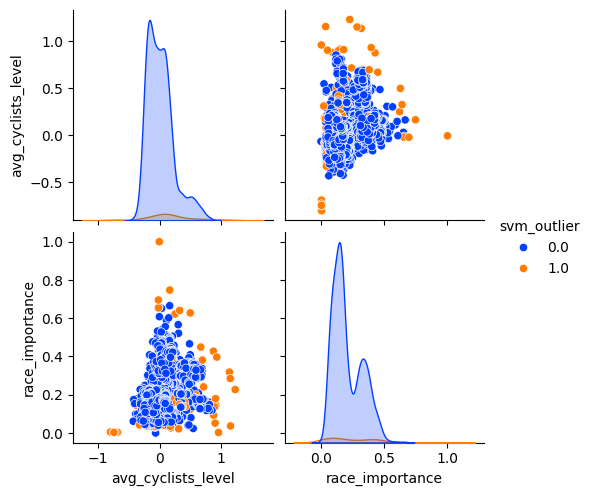

In [34]:
# Classify points as outliers or not

races_with_outlier_score.drop(columns=['svm_degree'], inplace=True)

sns.pairplot(races_with_outlier_score[races_numeric_columns + ["svm_outlier"]], hue='svm_outlier', diag_kind='kde', palette='bright')
plt.show()

In [35]:
races_with_outlier_score["svm_outlier"].value_counts()

svm_outlier
0.0    2485
1.0     129
Name: count, dtype: int64

Analyze some of them

In [36]:
outliers = races_with_outlier_score[races_with_outlier_score['svm_outlier'] == 1]
outliers.drop(columns=["svm_outlier"]).head()

,_url,name,points,length,climb_total,profile,startlist_quality,is_tarmac,start_date,duration,...,avg_slope,min_duration,duration_to_length,real_name,startlist_entropy,points_entropy,difficulty_index_2,top_complex_races_2,lof_degree,connectivity_outlier
36,dauphine/2016/prologue,Criterium du Dauphiné,50.0,0.040,0.348,5.0,1182,True,2016-06-05,00:11:36,...,870.0000,0.193333,48.3333,dauphine,3.528066,-0.000000,1.439091,Top 20,1.153317,0
141,giro-d-italia/2001/stage-13,Giro d'Italia,80.0,2.250,5.906,5.0,920,True,2001-06-01,07:24:48,...,262.4889,7.413333,32.9481,giro-d-italia,4.498913,0.128518,1.349604,Top 150,1.134947,0
287,giro-d-italia/2008/stage-16,Giro d'Italia,80.0,0.129,1.084,5.0,1058,True,2008-05-26,00:40:26,...,840.3101,0.673889,52.2394,giro-d-italia,4.498913,0.128518,1.480069,Top 20,1.119489,0
328,giro-d-italia/2010/stage-16,Giro d'Italia,80.0,0.129,1.084,5.0,878,True,2010-05-25,00:41:28,...,840.3101,0.691111,53.5745,giro-d-italia,4.498913,0.128518,1.462487,Top 20,1.170247,0
346,giro-d-italia/2011/stage-15,Giro d'Italia,80.0,2.290,6.939,5.0,891,True,2011-05-22,07:27:14,...,303.0131,7.453889,32.5497,giro-d-italia,4.498913,0.128518,1.347896,Top 150,1.326136,1


Analyze which cyclists has both outlier score positive

In [37]:
outliers = races_with_outlier_score[(races_with_outlier_score['svm_outlier'] == 1) & (races_with_outlier_score['connectivity_outlier'] == 1)]
print(f"In total there are {int(len(outliers))} data with both outlier scores positive\n")
outliers.drop(columns=["svm_outlier", "connectivity_outlier"]).head()


In total there are 35 data with both outlier scores positive



,_url,name,points,length,climb_total,profile,startlist_quality,is_tarmac,start_date,duration,...,season,avg_slope,min_duration,duration_to_length,real_name,startlist_entropy,points_entropy,difficulty_index_2,top_complex_races_2,lof_degree
346,giro-d-italia/2011/stage-15,Giro d'Italia,80.0,2.290,6.939,5.0,891,True,2011-05-22,07:27:14,...,Spring,303.0131,7.453889,32.5497,giro-d-italia,4.498913,0.128518,1.347896,Top 150,1.326136
617,gran-camino/2022/stage-1,Gran Camiño,20.0,1.650,1.993,2.0,225,True,2022-02-24,03:56:59,...,Winter,120.7879,3.949722,23.9377,gran-camino,0.985228,-0.000000,0.259561,Top 2000,1.627361
618,gran-camino/2022/stage-2,Gran Camiño,20.0,1.776,3.006,3.0,225,True,2022-02-25,04:35:52,...,Winter,169.2568,4.597778,25.8884,gran-camino,0.985228,-0.000000,0.547961,Top 1300,2.519621
619,gran-camino/2022/stage-3,Gran Camiño,20.0,1.484,2.669,2.0,225,True,2022-02-26,03:42:42,...,Winter,179.8518,3.711667,25.0112,gran-camino,0.985228,-0.000000,0.287024,Top 2000,1.929246
620,gran-camino/2022/stage-4,Gran Camiño,20.0,0.158,0.208,1.0,225,True,2022-02-27,00:20:19,...,Winter,131.6456,0.338611,21.4311,gran-camino,0.985228,-0.000000,-0.069260,Rest,2.294679


## Isolation forest


In [38]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest algorithm with a lower contamination value
isolation_forest = IsolationForest(n_estimators=200, contamination=0.04, n_jobs=-1, random_state=42)
isolation_forest.fit(races_df)

# Compute the outlier scores
outlier_scores = isolation_forest.decision_function(races_df)       # negative values are outliers
outlier_predictions = isolation_forest.predict(races_df)

# Add the outlier scores to the dataframe
races_with_outlier_score['isolation_forest_score'] = outlier_scores
races_with_outlier_score['isolation_forest_outlier'] = (outlier_predictions == -1).astype(int)

print(races_with_outlier_score['isolation_forest_outlier'].value_counts())

isolation_forest_outlier
0    2509
1     105
Name: count, dtype: int64


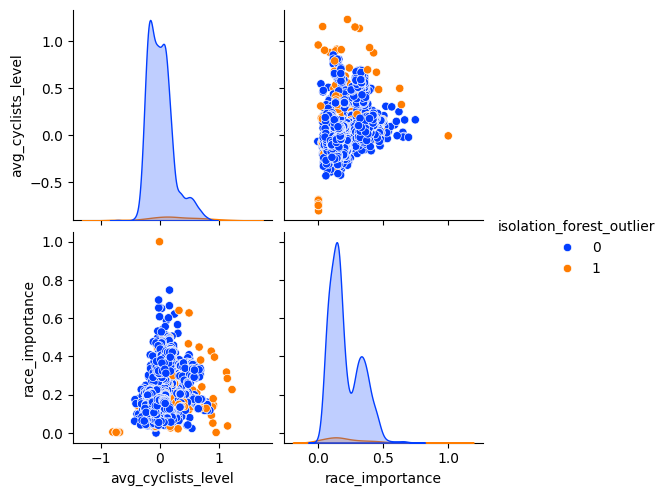

In [39]:
races_with_outlier_score.drop(columns=['isolation_forest_score'], inplace=True)

sns.pairplot(races_with_outlier_score[races_numeric_columns + ["isolation_forest_outlier"]], hue="isolation_forest_outlier", diag_kind='kde', palette='bright')
plt.show()

## ENSAMBLING DECISION

Check when at least two outlier score are positive to classify a point as an outlier

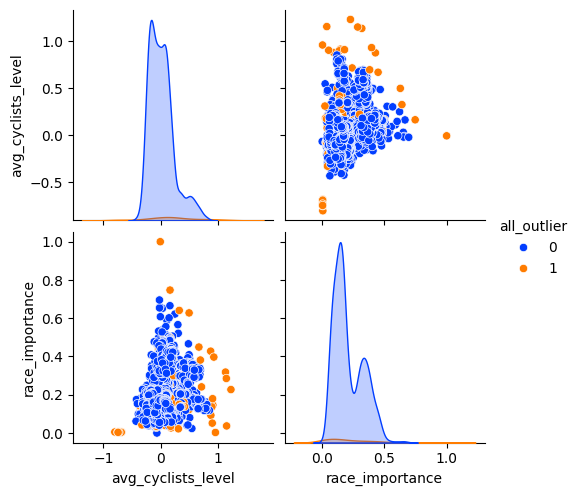

In [40]:
cond1 = (races_with_outlier_score['isolation_forest_outlier'] == 1) & (races_with_outlier_score['svm_outlier'] == 1) 
cond2 = (races_with_outlier_score['isolation_forest_outlier'] == 1) & (races_with_outlier_score['connectivity_outlier'] == 1)
cond3 = (races_with_outlier_score['svm_outlier'] == 1) & (races_with_outlier_score['connectivity_outlier'] == 1)
cond = cond1 | cond2 | cond3

races_with_outlier_score['all_outlier'] = (cond).astype(int)

sns.pairplot(races_with_outlier_score[races_numeric_columns + ["all_outlier"]], hue='all_outlier', diag_kind='kde', palette='bright')
plt.show()

Count how many outliers individued by both methods

In [41]:
print(races_with_outlier_score['all_outlier'].value_counts())

all_outlier
0    2525
1      89
Name: count, dtype: int64


### Trying to characterize the outlier

First isolate outliers in a separate df in order to analyze the distribution of removed rows

In [42]:
outlier_df = races_with_outlier_score[races_numeric_columns + ['all_outlier']]
outlier_df = outlier_df[outlier_df['all_outlier'] == 1]

scaler = MinMaxScaler()

# Normalize the data
normalized_outlier_df = pd.DataFrame(scaler.fit_transform(outlier_df[races_numeric_columns]), columns=races_numeric_columns)

normalized_outlier_df.describe()

,avg_cyclists_level,race_importance
count,89.000000,89.000000
mean,0.492231,0.206221
std,0.231024,0.189942
min,0.000000,0.000000
25%,0.356842,0.055058
50%,0.474485,0.147476
75%,0.610878,0.316522
max,1.000000,1.000000


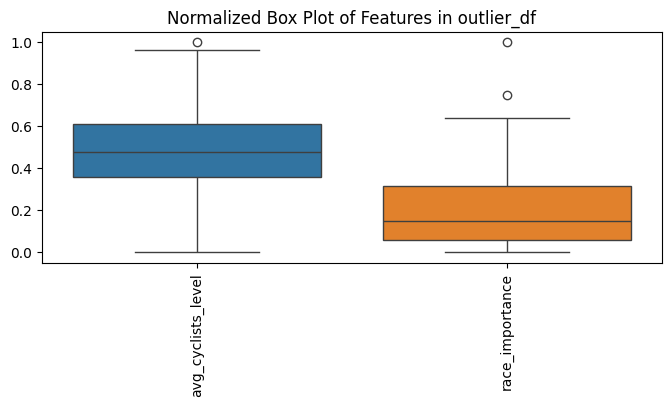

In [43]:
 # Create a box plot
plt.figure(figsize=(8, 3))
sns.boxplot(data=normalized_outlier_df[races_numeric_columns])
plt.xticks(rotation=90)
plt.title('Normalized Box Plot of Features in outlier_df')
plt.show()

In [44]:
# Create a pairplot to visualize the relationships between features in the normalized outlier dataframe
#sns.pairplot(normalized_outlier_df)
# plt.show()

In [45]:
races_with_outlier_score = races_with_outlier_score[races_with_outlier_score['all_outlier'] != 1]
races_with_outlier_score.drop(columns=['connectivity_outlier', 'svm_outlier', 'isolation_forest_outlier' ,'all_outlier', 'lof_degree'], inplace=True)

In [46]:
races_with_outlier_score.value_counts("top_complex_races")

top_complex_races
Top 1700    396
Top 2400    391
Top 500     319
Top 2000    297
Top 1300    281
Top 1000    246
Top 750     246
Rest        208
Top 150      91
Top 50       30
Top 20       20
Name: count, dtype: int64

### Saving the dataset

In [47]:
races_with_outlier_score.columns

Index(['_url', 'name', 'points', 'length', 'climb_total', 'profile',
       'startlist_quality', 'is_tarmac', 'start_date', 'duration',
       'cyclist_number', 'avg_cyclists_level', 'average_age',
       'race_importance', 'top_races', 'difficulty_idx', 'top_complex_races',
       'season', 'avg_slope', 'min_duration', 'duration_to_length',
       'real_name', 'startlist_entropy', 'points_entropy',
       'difficulty_index_2', 'top_complex_races_2'],
      dtype='object')

In [48]:
races_with_outlier_score.to_csv('../dataset/races_outlier.csv', index=False)